# Baseline network + pruning + quantization

This notebook trains the baseline network with exact same architecture as the one in paper [Recognition of handwritten Latin characters with diacritics using CNN](https://journals.pan.pl/dlibra/publication/136210/edition/119099/content/bulletin-of-the-polish-academy-of-sciences-technical-sciences-recognition-of-handwritten-latin-characters-with-diacritics-using-cnn-lukasik-edyta-charytanowicz-malgorzata-milosz-marek-tokovarov-michail-kaczorowska-monika-czerwinski-dariusz-zientarski-tomasz-2021-69-no-1?language=en)

Model architecture description:

"The architecture of the concrete CNN is shown in Fig. 2.
The input is a 32x32 binarized matrix. The input is then prop-
agated through 12 adaptable layers. First come two convolu-
tional layers having 32 filters with the size of 3x3 and stride 1.
Secondly, the output of the convolutional layer is fed to the
ReLU function. The output is down-sampled using a max-pool-
ing operation with a 2x2 stride. Next, the dropout technique is
used with the coefficient 0.25. The four operations (two con-
volutions, nonlinearity, max-pooling, and dropout) are repeated,
using 64 filters for the convolutional layers. The output of the
last layer is then flattened and fed through a fully connected
layer with 256 neurons and ReLU nonlinearities, dropped out
with the 0.25 coefficient, and a final output layer is fully con-
nected with a Softmax activation function. The Adam optimizer
and the cross-entropy loss function were used in the network. 
The output is a probability distribution over 89 classes."


Additionally, this network was pruned and quantized after training.



After training, model is serialized and uploaded to W&B project.

In [1]:
! pip install tensorflow-model-optimization

In [2]:
! pip install keras-flops

In [3]:
! pip install tensorboard_plugin_profile

In [1]:
import pathlib
import shutil
import os
import datetime
import numpy as np
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from keras_flops import get_flops
import matplotlib.pyplot as plt

from typing import List

def load_data(run, artifact_name = "phcd_paper_splits_tfds") -> List[tf.data.Dataset]:
    """
    Downloads datasets from a wandb artifact and loads them into a list of tf.data.Datasets.
    """

    artifact = run.use_artifact(f"master-thesis/{artifact_name}:latest")
    artifact_dir = pathlib.Path(
        f"./artifacts/{artifact.name.replace(':', '-')}"
    ).resolve()
    if not artifact_dir.exists():
        artifact_dir = artifact.download()
        artifact_dir = pathlib.Path(artifact_dir).resolve()

    # if tf.__version__ minor is less than 10, use
    # tf.data.experimental.load instead of tf.data.Dataset.load

    if int(tf.__version__.split(".")[1]) < 10:
        load_function = tf.data.experimental.load
    else:
        load_function = tf.data.Dataset.load
    
    output_list = []
    for split in ["train", "test", "val"]:
        ds = load_function(str(artifact_dir / split), compression="GZIP")
        output_list.append(ds)
    
    return output_list

def get_number_of_classes(ds: tf.data.Dataset) -> int:
    """
    Returns the number of classes in a dataset.
    """
    labels_iterator= ds.map(lambda x, y: y).as_numpy_iterator()
    labels = np.concatenate(list(labels_iterator))
    return len(np.unique(labels))

def get_number_of_examples(ds: tf.data.Dataset) -> int:
    """
    Returns the number of examples in a dataset.
    """
    return sum(1 for _ in ds)

def preprocess_dataset(ds: tf.data.Dataset, batch_size: int, cache: bool = True) -> tf.data.Dataset:
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # normalize
    ds = ds.unbatch().batch(batch_size)
    if cache:
        ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def calculate_model_size_on_disk(path: str) -> int:
    return pathlib.Path(path).stat().st_size    

def calculate_model_num_parameters(model: tf.keras.Model) -> int:
    return model.count_params()

def calculate_model_flops(summary) -> float:
    # from run.summary get GFLOPs or GFLOPS whichever is available
    if "GFLOPs" in summary.keys():
        return summary.get("GFLOPs")
    elif "GFLOPS" in summary.keys():
        return summary.get("GFLOPS")
    else:
        return 0

def calculate_gflops(model):
    flops = get_flops(model, batch_size=1)
    print(f"GFLOPS: {flops / 10 ** 9:.03}")

def plot_history(history, title):
    plt.figure(figsize=(15,7))
    plt.suptitle(title)
    
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

2023-01-31 11:43:22.199520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Available devices: ", tf.config.list_physical_devices())

Num GPUs Available:  1
Available devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-31 11:43:24.515608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 11:43:24.519693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 11:43:24.519936: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.


# Baseline model

In [3]:
defaults = dict(
    batch_size=32*2,
    epochs=7,    
    optimizer="adam"
)

model_name = "baseline"

artifact_name = "phcd_paper_splits_tfds"
run = wandb.init(project="master-thesis", job_type="training", name=model_name, config=defaults, tags=[artifact_name])
    
# hyperparameters
epochs = wandb.config.epochs
bs = wandb.config.batch_size

ds_train, ds_test, ds_val = load_data(run, artifact_name=artifact_name)

num_classes = get_number_of_classes(ds_val)

ds_train = preprocess_dataset(ds_train, batch_size=bs)
ds_val = preprocess_dataset(ds_val, batch_size=bs)
ds_test = preprocess_dataset(ds_test, batch_size=bs, cache=False)

'''
The architecture of the concrete CNN is shown in Fig. 2.
The input is a 32x32 binarized matrix. 
The input is then propagated through 12 adaptable layers. 
First come two convolutional layers having 32 filters with the size of 3x3 and stride 1.
Secondly, the output of the convolutional layer is fed to the
ReLU function. The output is down-sampled using a max-pool-
ing operation with a 2x2 stride. Next, the dropout technique is
used with the coefficient 0.25. The four operations (two con-
volutions, nonlinearity, max-pooling, and dropout) are repeated,
using 64 filters for the convolutional layers. The output of the
last layer is then flattened and fed through a fully connected
layer with 256 neurons and ReLU nonlinearities, dropped out
with the 0.25 coefficient, and a final output layer is fully con-
nected with a Softmax activation function. The Adam optimizer
and the cross-entropy loss function were used in the network
[24]. The output is a probability distribution over 89 classes.
'''

model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(32, 32, 1)),
        
        # 2 Convolutional layers with 32 filters, 3x3 size, and stride 1
        tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu'),
        
        # Max-pooling operation with 2x2 stride
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        # Dropout with coefficient 0.25
        tf.keras.layers.Dropout(0.25),
        
        # Repeat above 4 operations using 64 filters
        tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.25),
        
        # Flatten the output and feed through fully connected layer with 256 neurons
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),

        # Dropout with coefficient 0.25
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gratkadlafana. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact phcd_paper_splits_tfds:latest, 163.87MB. 27 files... 
wandb:   27 of 27 files downloaded.  
Done. 0:0:0.0


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-01-31 11:43:28.269961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 11:43:28.270732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 11:43:28.270950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 11:43:28.271147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_nod

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                        

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Epoch 1/7


2023-01-31 11:43:30.010052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 11:43:30.010105: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-31 11:43:30.010277: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-01-31 11:43:30.010779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 11:43:30.010979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 11:43:30.011298: I tensor

6977/6977 [==============================] - 79s 11ms/step - loss: 0.8470 - accuracy: 0.7203 - val_loss: 0.5225 - val_accuracy: 0.8038
Epoch 2/7
6977/6977 [==============================] - 77s 11ms/step - loss: 0.6008 - accuracy: 0.7835 - val_loss: 0.4749 - val_accuracy: 0.8182
Epoch 3/7
6977/6977 [==============================] - 77s 11ms/step - loss: 0.5621 - accuracy: 0.7947 - val_loss: 0.4556 - val_accuracy: 0.8238
Epoch 4/7
6977/6977 [==============================] - 77s 11ms/step - loss: 0.5414 - accuracy: 0.8007 - val_loss: 0.4385 - val_accuracy: 0.8304
Epoch 5/7
6977/6977 [==============================] - 77s 11ms/step - loss: 0.5299 - accuracy: 0.8041 - val_loss: 0.4349 - val_accuracy: 0.8318
Epoch 6/7
6977/6977 [==============================] - 77s 11ms/step - loss: 0.5189 - accuracy: 0.8072 - val_loss: 0.4286 - val_accuracy: 0.8344
Epoch 7/7
6977/6977 [==============================] - 78s 11ms/step - loss: 0.5122 - accuracy: 0.8093 - val_loss: 0.4184 - val_accuracy: 0.

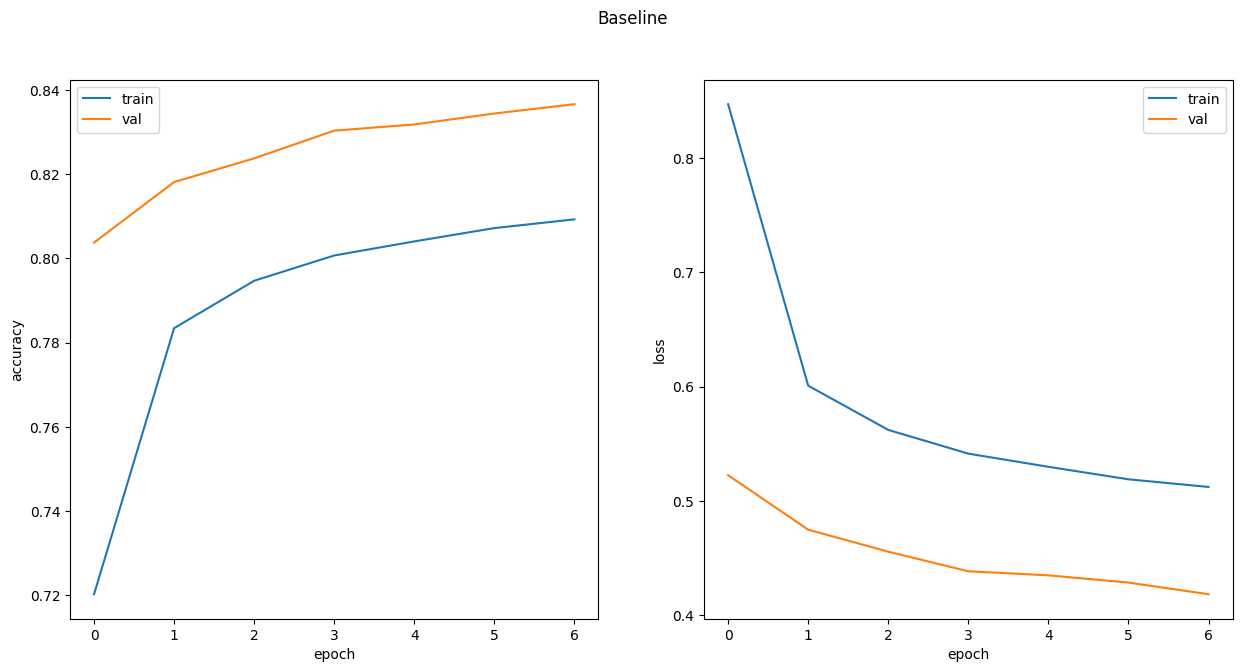

In [4]:
history = model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[
        WandbCallback(
            compute_flops=True, 
            save_model=False, 
            log_weights=False, 
            log_gradients=False
        )
    ],
)

plot_history(history, "Baseline")
tf.keras.models.save_model(model, 'model_baseline.h5', include_optimizer=False)

In [6]:
# evaluate model on ds_test and log to wandb
test_loss_before, test_acc_before = model.evaluate(ds_test)

# calculate model size on disk, flops and number of parameters
# flops = calculate_gflops(model)
flops = 0
num_parameters = calculate_model_num_parameters(model)
disk_size = calculate_model_size_on_disk('model_baseline.h5')


data_to_log = {
    "test loss": test_loss_before, 
    "test accuracy": test_acc_before, 
    "number of parameters": num_parameters,
    "disk size": disk_size, 
    "model flops": flops,
    }
print(data_to_log)
wandb.log(data_to_log)
run.finish()

1744/1744 [==============================] - 9s 5ms/step - loss: 0.4175 - accuracy: 0.8374
{'test loss': 0.4174608886241913, 'test accuracy': 0.8373808264732361, 'number of parameters': 497721, 'disk size': 2025880, 'model flops': 0}


accuracy,▁▆▇▇███
disk size,▁
epoch,▁▂▃▅▆▇█
loss,█▃▂▂▁▁▁
model flops,▁
number of parameters,▁
test accuracy,▁
test loss,▁
val_accuracy,▁▄▅▇▇██
val_loss,█▅▄▂▂▂▁
GFLOPs,0.01431


# Quantization - allows for better accuracy

In [7]:
run = wandb.init(project="master-thesis", job_type="training", name=f"{model_name}_quantized", config=defaults, tags=[artifact_name])

quantize_model = tfmot.quantization.keras.quantize_model

quant_epochs = 2
base_model = tf.keras.models.load_model('model_baseline.h5')

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(base_model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 32, 32, 1)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 30, 30, 32)       387       
 erV2)                                                           
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 28, 28, 32)       9315      
 pperV2)                                                         
                                                                 
 quant_max_pooling2d (Quanti  (None, 14, 14, 32)       1         
 zeWrapperV2)                                                    
                                                                 
 quant_dropout (QuantizeWrap  (None, 14, 14, 32)       1

Epoch 1/2


2023-01-31 12:13:11.975659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 12:13:11.978097: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-31 12:13:11.978278: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-01-31 12:13:11.979517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 12:13:11.979760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 12:13:11.979948: I tensor

6977/6977 [==============================] - 171s 24ms/step - loss: 0.5088 - accuracy: 0.8099 - val_loss: 0.4151 - val_accuracy: 0.8364
Epoch 2/2
6977/6977 [==============================] - 169s 24ms/step - loss: 0.5038 - accuracy: 0.8113 - val_loss: 0.4130 - val_accuracy: 0.8363


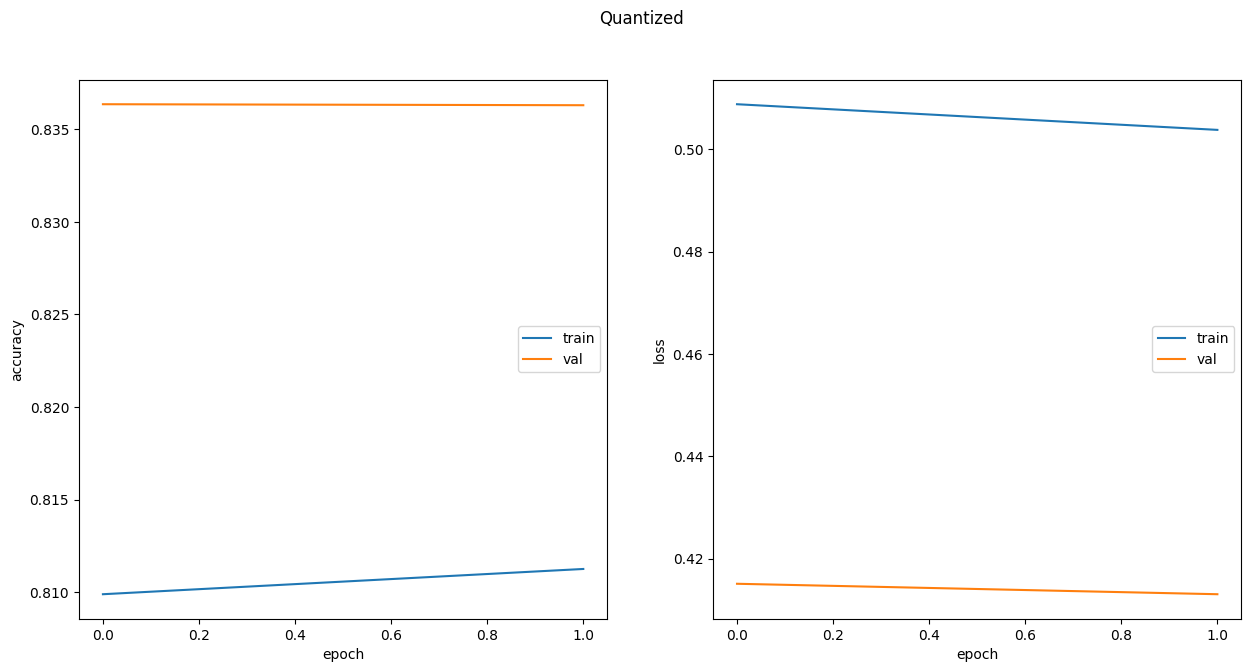

In [8]:
history = q_aware_model.fit(
    ds_train,
    epochs=quant_epochs,
    validation_data=ds_val,
    callbacks=[
        WandbCallback(
            compute_flops=True, 
            save_model=False, 
            log_weights=False, 
            log_gradients=False
        )
    ],
)


plot_history(history, "Quantized")
tf.keras.models.save_model(q_aware_model, 'model_quantized.h5', include_optimizer=False)

In [9]:
# evaluate model on ds_test and log to wandb
test_loss_after, test_acc_after = model.evaluate(ds_test)

# calculate model size on disk, flops and number of parameters
# flops = calculate_gflops(q_aware_model)
num_parameters = calculate_model_num_parameters(q_aware_model)
disk_size = calculate_model_size_on_disk('model_quantized.h5')

data_to_log = {
    "test loss": test_loss_after, 
    "test accuracy": test_acc_after, 
    "number of parameters": num_parameters,
    "disk size": disk_size, 
    "model flops": flops,
    }
print(data_to_log)
wandb.log(data_to_log)

test_acc_quantize = test_acc_after
run.finish()

1744/1744 [==============================] - 9s 5ms/step - loss: 0.4175 - accuracy: 0.8374
{'test loss': 0.4174608886241913, 'test accuracy': 0.8373808264732361, 'number of parameters': 498136, 'disk size': 2060720, 'model flops': 0}


accuracy,▁█
disk size,▁
epoch,▁█
loss,█▁
model flops,▁
number of parameters,▁
test accuracy,▁
test loss,▁
val_accuracy,█▁
val_loss,█▁
GFLOPs,0.01431


# Pruning model - allows for smaller size (after compression)

In [14]:
run = wandb.init(project="master-thesis", job_type="training", name=f"{model_name}_pruned", config=defaults, tags=[artifact_name])

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

prune_epochs = 4
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
  }

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

base_model = tf.keras.models.load_model('model_baseline.h5')
model_sparse = prune_low_magnitude(base_model, **pruning_params)

# Use smaller learning rate for fine-tuning
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model_sparse.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=opt,
  metrics=['accuracy'])

model_sparse.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 30, 30, 32)       610       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_conv2d_  (None, 28, 28, 32)       18466     
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 14, 14, 32)       1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_dropout  (None, 14, 14, 32)       1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_conv2d_  (None, 12, 12, 64)       3

2023-01-31 13:01:51.362014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 13:01:51.362064: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-31 13:01:51.362275: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-01-31 13:01:51.362800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 13:01:51.363007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 13:01:51.363212: I tensor

Epoch 1/4


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-01-31 13:01:53.300824: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/prune_low_magnitude_dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6977/6977 [==============================] - 126s 18ms/step - loss: 2.3699 - accuracy: 0.4878 - val_loss: 0.4959 - val_accuracy: 0.8090
Epoch 2/4
6977/6977 [==============================] - 122s 18ms/step - loss: 0.5796 - accuracy: 0.7828 - val_loss: 0.4457 - val_accuracy: 0.8257
Epoch 3/4
6977/6977 [==============================] - 119s 17ms/step - loss: 0.5461 - accuracy: 0.7936 - val_loss: 0.4326 - val_accuracy: 0.8313
Epoch 4/4
6977/6977 [==============================] - 140s 20ms/step - loss: 0.5318 - accuracy: 0.7994 - val_loss: 0.4260 - val_accuracy: 0.8346


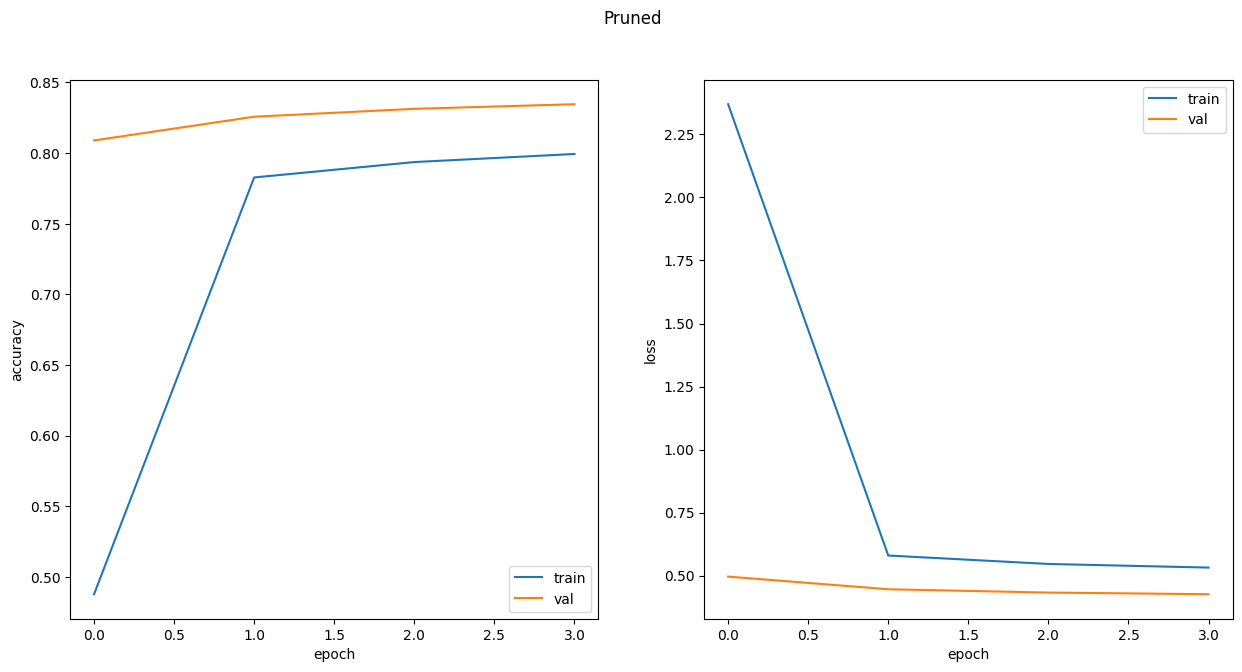

In [15]:
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    WandbCallback(
            compute_flops=True, 
            save_model=False, 
            log_weights=False, 
            log_gradients=False
        )
]

history = model_sparse.fit(
    ds_train,
    epochs=prune_epochs,
    validation_data=ds_val,
    callbacks=callbacks
)

plot_history(history, "Pruned")
tf.keras.models.save_model(model_sparse, 'model_sparse.h5', include_optimizer=False)

In [12]:
# evaluate model on ds_test and log to wandb
test_loss_after, test_acc_after = model_sparse.evaluate(ds_test)

# calculate model size on disk, flops and number of parameters
## flops = calculate_gflops(model_sparse)
num_parameters = calculate_model_num_parameters(model_sparse)
disk_size = calculate_model_size_on_disk('model_sparse.h5')

data_to_log = {
    "test loss": test_loss_before, 
    "test accuracy": test_acc_before, 
    "number of parameters": num_parameters,
    "disk size": disk_size, 
    "model flops": flops,
    }
print(data_to_log)
wandb.log(data_to_log)

test_acc_prune = test_acc_after
run.finish()

1744/1744 [==============================] - 10s 6ms/step - loss: 0.4564 - accuracy: 0.8273
{'test loss': 0.4174608886241913, 'test accuracy': 0.8373808264732361, 'number of parameters': 994923, 'disk size': 4040856, 'model flops': 0}


accuracy,▁▄▇█
disk size,▁
epoch,▁▃▆█
loss,█▄▂▁
model flops,▁
number of parameters,▁
test accuracy,▁
test loss,▁
val_accuracy,▁▅▇█
val_loss,█▄▂▁
accuracy,0.78856


# PQAT - pruning preserving quantization aware training

Epoch 1/4


2023-01-31 13:16:33.746456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 13:16:33.746514: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-31 13:16:33.746696: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-01-31 13:16:33.747243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 13:16:33.747450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 13:16:33.747723: I tensor

6977/6977 [==============================] - 178s 25ms/step - loss: 0.5183 - accuracy: 0.8054 - val_loss: 0.4131 - val_accuracy: 0.8383
Epoch 2/4
6977/6977 [==============================] - 174s 25ms/step - loss: 0.5013 - accuracy: 0.8115 - val_loss: 0.4078 - val_accuracy: 0.8377
Epoch 3/4
6977/6977 [==============================] - 173s 25ms/step - loss: 0.4963 - accuracy: 0.8130 - val_loss: 0.4001 - val_accuracy: 0.8391
Epoch 4/4
6977/6977 [==============================] - 177s 25ms/step - loss: 0.4914 - accuracy: 0.8142 - val_loss: 0.3980 - val_accuracy: 0.8409


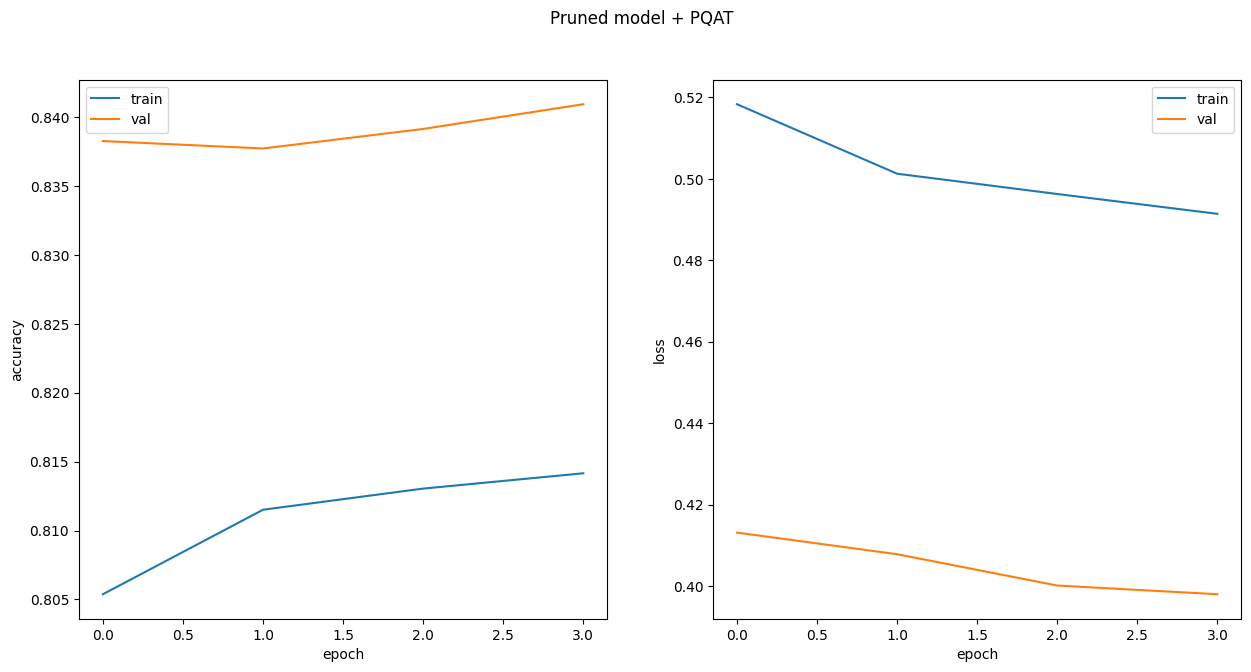

In [17]:
run = wandb.init(project="master-thesis", job_type="training", name=f"{model_name}_pqat", config=defaults, tags=[artifact_name])

# PQAT
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(model_sparse)
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(stripped_pruned_model)
pqat_model = tfmot.quantization.keras.quantize_apply(
              quant_aware_annotate_model,
              tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())

pqat_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='./prune_summary'),
    WandbCallback(
            compute_flops=True, 
            save_model=False, 
            log_weights=False, 
            log_gradients=False
        )
]

history = pqat_model.fit(
    ds_train,
    epochs=prune_epochs,
    validation_data=ds_val,
    callbacks=callbacks,
)
plot_history(history, "Pruned model + PQAT")
tf.keras.models.save_model(pqat_model, 'model_quantized_sparse.h5', include_optimizer=False)

In [19]:
# evaluate model on ds_test and log to wandb
test_loss_after, test_acc_after = pqat_model.evaluate(ds_test)

# calculate model size on disk, flops and number of parameters
# flops = calculate_gflops(pqat_model)
num_parameters = calculate_model_num_parameters(pqat_model)
disk_size = calculate_model_size_on_disk('model_quantized_sparse.h5')

data_to_log = {
    "test loss": test_loss_before, 
    "test accuracy": test_acc_before, 
    "number of parameters": num_parameters,
    "disk size": disk_size, 
    "model flops": flops,
    }
print(data_to_log)
wandb.log(data_to_log)

test_acc_pqat = test_acc_after
run.finish()

1744/1744 [==============================] - 18s 10ms/step - loss: 0.3980 - accuracy: 0.8412
{'test loss': 0.4174608886241913, 'test accuracy': 0.8373808264732361, 'number of parameters': 498136, 'disk size': 2060720, 'model flops': 0}


accuracy,▁▆▇█
disk size,▁
epoch,▁▃▆█
loss,█▄▂▁
model flops,▁
number of parameters,▁
test accuracy,▁
test loss,▁
val_accuracy,▂▁▄█
val_loss,█▆▂▁
GFLOPs,0.01456


# Summary & Tensorboard

In [20]:
print('Baseline test accuracy:', test_acc_before) 
print('Quantized test accuracy:', test_acc_quantize)
print('Pruned test accuracy:', test_acc_prune)
print('PQAT test accuracy:', test_acc_pqat)

Baseline test accuracy: 0.8373808264732361
Quantized test accuracy: 0.8373808264732361
Pruned test accuracy: 0.8273173570632935
PQAT test accuracy: 0.8411893248558044


In [21]:
import zipfile

with zipfile.ZipFile('model_baseline.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write('model_baseline.h5')

with zipfile.ZipFile('model_quantized.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write('model_quantized.h5')
    
with zipfile.ZipFile('model_sparse.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write('model_sparse.h5')

with zipfile.ZipFile('model_quantized_sparse.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write('model_quantized_sparse.h5')

print('Zipped model files size:\n')
b_size = os.path.getsize('model_baseline.zip')
q_size = os.path.getsize('model_quantized.zip')
s_size = os.path.getsize('model_sparse.zip')
q_s_size = os.path.getsize('model_quantized_sparse.zip')
print('Baseline: {} bytes'.format(b_size))
print('Quantized: {} bytes'.format(q_size))
print('Sparse:   {} bytes'.format(s_size))
print('PQAT:     {} bytes'.format(q_s_size))

quantized_model_rel = (b_size-q_size)/b_size
sparse_model_rel
pqat_model_rel = 
print(f'Quantized model is {((b_size-q_size)/b_size * 100):.2f}% smaller')
print(f'Pruned model is {((b_size-s_size)/b_size * 100):.2f}% smaller')
print(f'PQAT model is {((b_size-q_s_size)/b_size * 100):.2f}% smaller')

Zipped model files size:

Baseline: 1862702 bytes
Quantized: 1868111 bytes
Sparse:   1265183 bytes
PQAT:     1158595 bytes
Quantized model is 0.29% smaller
Sparse model is 32.08% smaller
PQAT model is 37.80% smaller


In [22]:
%load_ext tensorboard
%tensorboard --logdir prune_summary